# Однофакторный анализ связи меток кред и фрод дефолта target.class с данными таблиц Фед ресурса efrsfdu базы данных VLS-MDM-DB MDM_Main по фичам  (часть 1)

    - сколько активных договоров имеется на дату принятия решения 
    - сколько до этого было договоров заключено на дату принятия решения 
    - сколько активных договоров только с транспортными средствами имеется на дату принятия решения 
    - сколько до этого было договоров только с транспортными средствами заключено на дату принятия решения 

Входные данные data/interm/target_features.pkl из feature_engineering.ipynb уже рассчитанные фичи

In [1]:
import pandas as pd

In [2]:
pre = '../../' # путь до главной директории проекта

%run ../init.ipynb #подгрузить нужные библиотеки
%run ../params.ipynb #параметры как логин пароль к БИ, параметры расчёта ( в нашем случае их нет)
%run ../init_mdm.ipynb
%run ../preprocessing/preprocessing_target.ipynb
%run ../ML_functions.ipynb
%run ../auxiliary/plots.ipynb

In [3]:
name = pre + "data/interm/target_features.pkl"
target_features = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных target_class with mdm features- {}".format(target_features.shape))

Размер считанных данных target_class with mdm features- (85798, 39)


In [4]:
# сюда таблицы будем кидать, для отчетов
name = pre + "data/interm/auxilary/analysis_features_part1.xlsx"
writer = ExcelWriter(name)

In [5]:
# target_features.head(2)

#### Теперь формируем выборки для фрод и кред дефолта

In [6]:
target_frod = Target(type='фрод', target_data=target_features) # это фрод дефолт, макс по обращению
target_cred = Target(type='кред', target_data=target_features)# это кред дефолт, макс по обращению

target_frod.print_param()
target_cred.print_param()


Параметры обработанной таблицы портфеля рисков  по обращениям:
	фрод дефолт = 1  у выборки 4708 из 63131 (7.46%)

Параметры обработанной таблицы портфеля рисков  по обращениям:
	кред дефолт = 1  у выборки 1977 из 43723 (4.52%)


In [7]:
# target_frod.data.head(2)

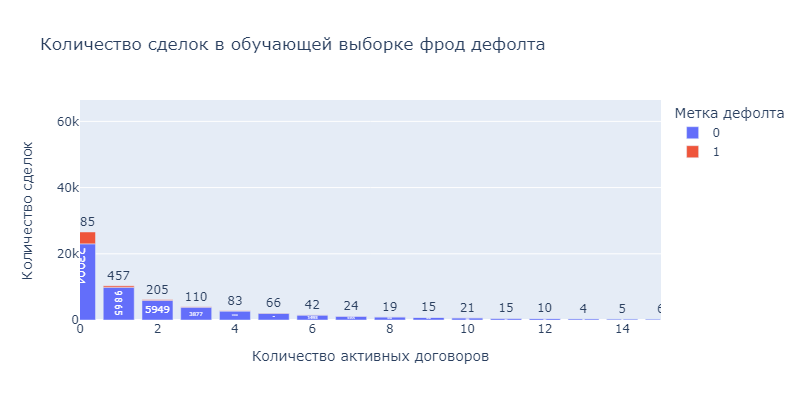

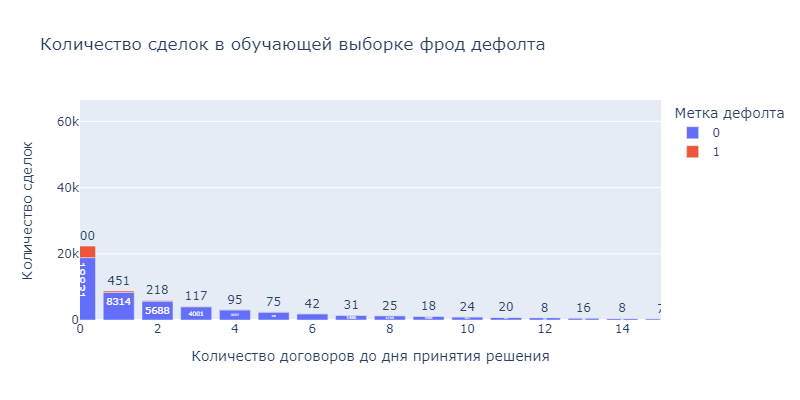

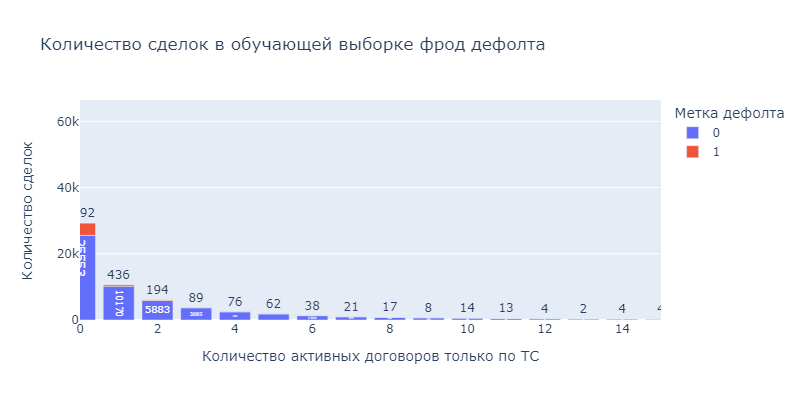

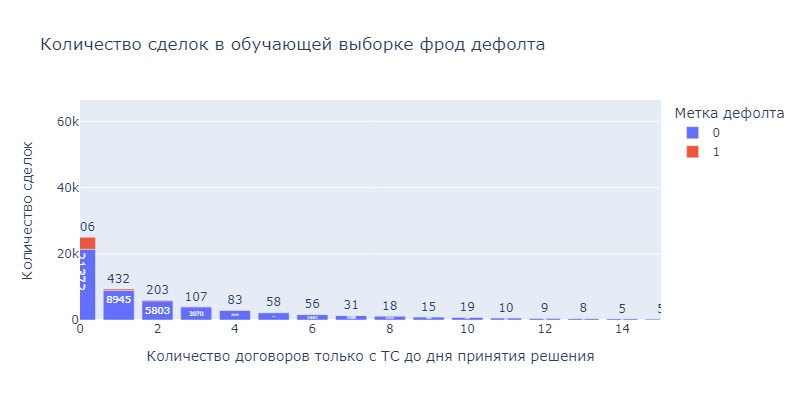

In [10]:
fig = plot_features_bar(target_frod.data, 'no_contracts_active', x_range =[0, 15])
fig = plot_features_bar(target_frod.data, 'no_contracts_total', x_range =[0, 15])
fig = plot_features_bar(target_frod.data, 'no_transp_active', x_range =[0, 15])
fig = plot_features_bar(target_frod.data, 'no_transport_total', x_range =[0, 15])

In [36]:
#  статиcтика по фичам
stat = target_frod.data['no_contracts_active'].apply(['min', 'max', 'mean']).to_frame().T.rename({'no_contracts_active':'frod_contracts_active'})
stat = stat.append(target_frod.data['no_contracts_total'].apply(['min', 'max', 'mean']).to_frame().T.rename({'no_contracts_total':'frod_contracts_total'}))
stat = stat.append(target_frod.data['no_transp_active'].apply(['min', 'max', 'mean']).to_frame().T.rename({'no_transp_active':'frod_transp_active'}))
stat = stat.append(target_cred.data['no_transport_total'].apply(['min', 'max', 'mean']).to_frame().T.rename({'no_transport_total':'frod_transport_total'}))

stat = stat.append(target_cred.data['no_contracts_active'].apply(['min', 'max', 'mean']).to_frame().T.rename({'no_contracts_active':'cred_contracts_active'}))
stat = stat.append(target_cred.data['no_contracts_total'].apply(['min', 'max', 'mean']).to_frame().T.rename({'no_contracts_total':'cred_contracts_total'}))
stat = stat.append(target_cred.data['no_transp_active'].apply(['min', 'max', 'mean']).to_frame().T.rename({'no_transp_active':'cred_transp_active'}))
stat = stat.append(target_cred.data['no_transport_total'].apply(['min', 'max', 'mean']).to_frame().T.rename({'no_transport_total':'cred_transport_total'}))

stat.to_excel(writer, sheet_name='stat_features')
stat


,min,max,mean
frod_contracts_active,0.0,674.0,4.446437
frod_contracts_total,0.0,824.0,6.835089
frod_transp_active,0.0,594.0,3.475598
frod_transport_total,0.0,645.0,4.816481
cred_contracts_active,0.0,674.0,4.054296
cred_contracts_total,0.0,824.0,6.384489
cred_transp_active,0.0,594.0,3.125998
cred_transport_total,0.0,645.0,4.816481


In [37]:
slice_ = slice(55395, 55397)
# target_frod.data[slice_]

#### Logregression количества договоров на день принятия решения по нашей сделке

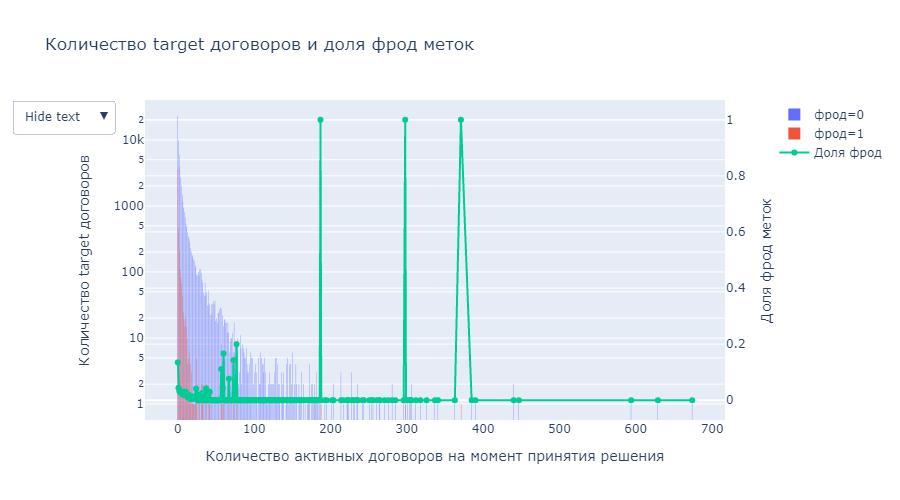

In [38]:
show_ActiveContracts(target_frod)

### Дефолтные сделки по всем договорам до даты принятия решения

{'rocauc': 0.67, 'accuracy': 0.48, 'recall': 0.9}
{'intercept': -0.4279, 'coef': array([-2.1668])}


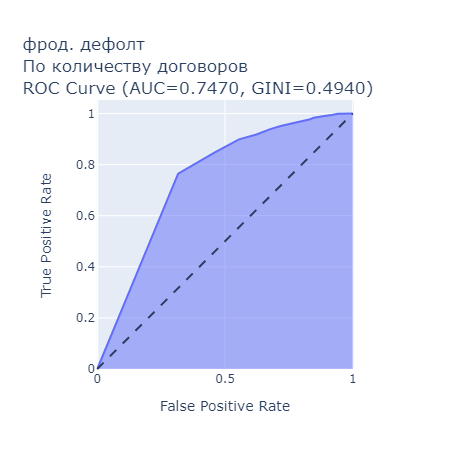

In [39]:
type = target_frod.type

X_raw = np.asarray(target_frod.data[['no_contracts_total']])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()

fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству договоров')



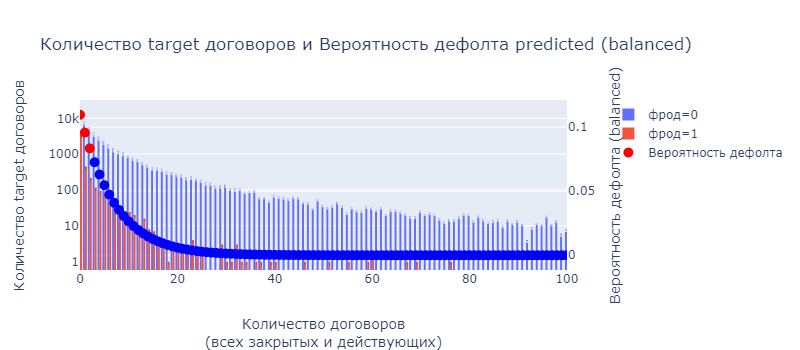

In [40]:
y_pred, y_prob = log.predict(np.arange(0, 200))
df_second = pd.DataFrame({'X':np.arange(0, 200), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_frod.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='no_contracts_total', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[0, 100], 
                height= 350, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = get_feature_name('no_contracts_total', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

### Дефолтные сделки по активным договорам на дату принятия решения

{'rocauc': 0.63, 'accuracy': 0.38, 'recall': 0.92}
{'intercept': -0.2315, 'coef': array([-1.4413])}


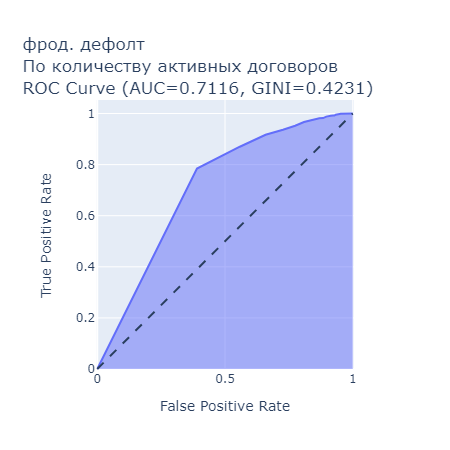

In [41]:
type = target_frod.type

X_raw = np.asarray(target_frod.data[['no_contracts_active']])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()

fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству активных договоров')

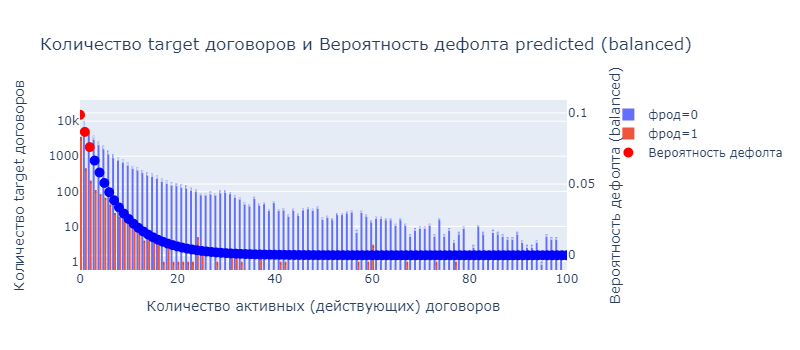

In [42]:
y_pred, y_prob = log.predict(np.arange(0, 200))
df_second = pd.DataFrame({'X':np.arange(0, 200), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_frod.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='no_contracts_active', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[0, 100], 
                height= 350, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = get_feature_name('no_contracts_active', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

### Дефолтные сделки по активным договорам только по ТС на дату принятия решения

{'rocauc': 0.64, 'accuracy': 0.43, 'recall': 0.89}
{'intercept': -0.2531, 'coef': array([-1.5703])}


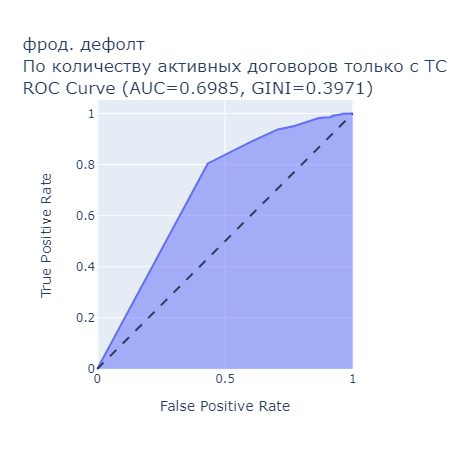

In [43]:
type = target_frod.type

X_raw = np.asarray(target_frod.data[['no_transp_active']])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()

fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству активных договоров только с ТС')


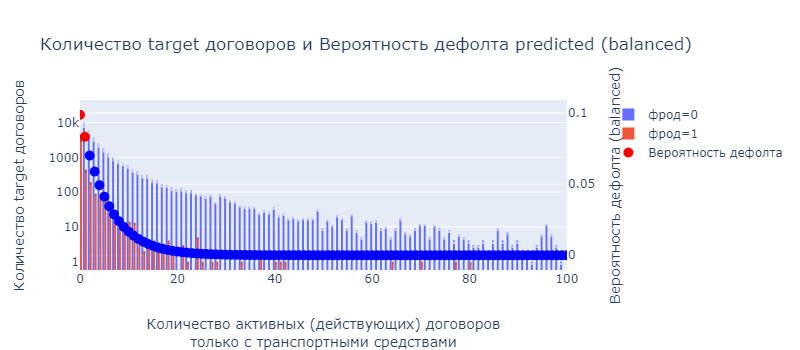

In [44]:
y_pred, y_prob = log.predict(np.arange(0, 200))
df_second = pd.DataFrame({'X':np.arange(0, 200), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_frod.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='no_transp_active', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[0, 100], 
                height= 350, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = get_feature_name('no_transp_active', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

### Дефолтные сделки по всем договорам только по ТС до даты принятия решения

{'rocauc': 0.65, 'accuracy': 0.43, 'recall': 0.92}
{'intercept': -0.429, 'coef': array([-2.2212])}


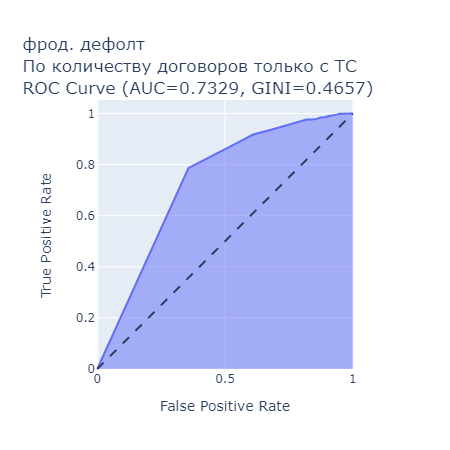

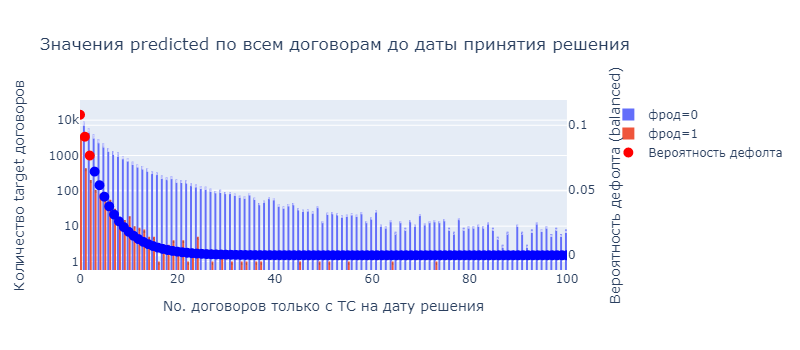

In [45]:
type = target_frod.type

X_raw = np.asarray(target_frod.data[['no_transport_total']])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству договоров только с ТС')

#  вывод исходных данных с вероятностями дефолта
y_pred, y_prob = log.predict(np.arange(0, 200))
df_second = pd.DataFrame({'X':np.arange(0, 200), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_frod.data.copy(), df_second=df_second,
              title="Значения predicted по всем договорам до даты принятия решения", 
                x_feature='no_transport_total', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[0, 100], 
                height= 350, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = 'No. договоров только с ТС на дату решения', y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

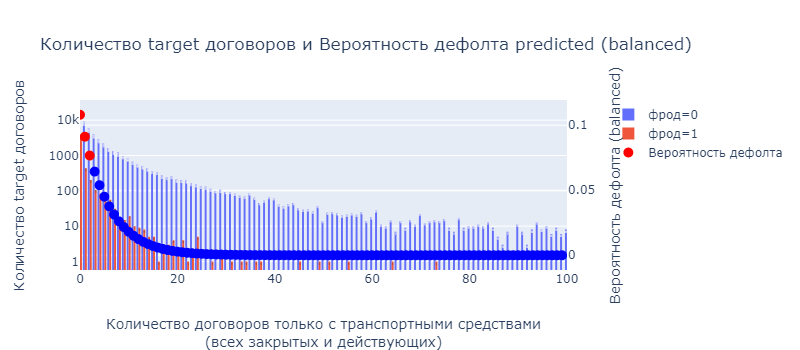

In [46]:
#  вывод исходных данных с вероятностями дефолта
y_pred, y_prob = log.predict(np.arange(0, 100))
df_second = pd.DataFrame({'X':np.arange(0, 100), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_frod.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='no_transport_total', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[0, 100], 
                height= 350, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = get_feature_name('no_transport_total', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

# Log - regression по меткам кред дефолта

In [47]:
# target_cred.data.head(1)

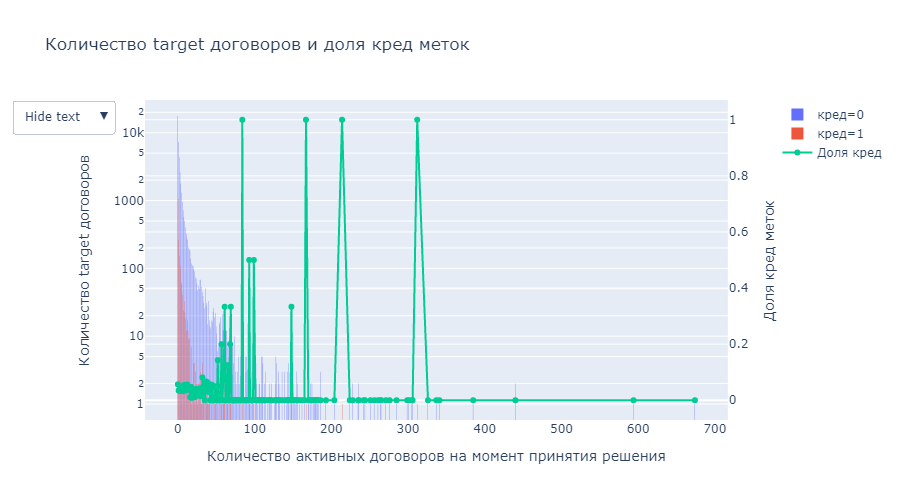

In [48]:
show_ActiveContracts(target_cred)

### Дефолтные сделки по всем договорам до даты принятия решения (кред метка)

{'rocauc': 0.53, 'accuracy': 0.28, 'recall': 0.81}
{'intercept': -0.0144, 'coef': array([-0.2153])}


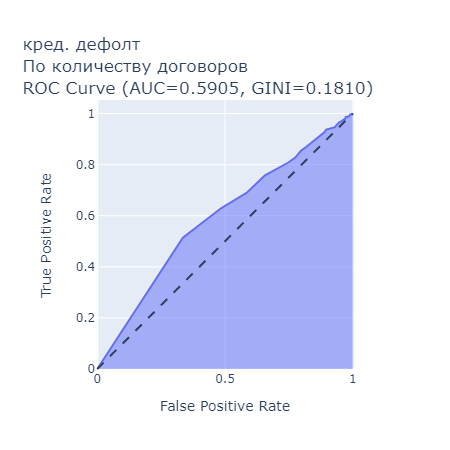

In [49]:
type = target_cred.type

X_raw = np.asarray(target_cred.data[['no_contracts_total']])
y = np.asarray(target_cred.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()

fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству договоров')

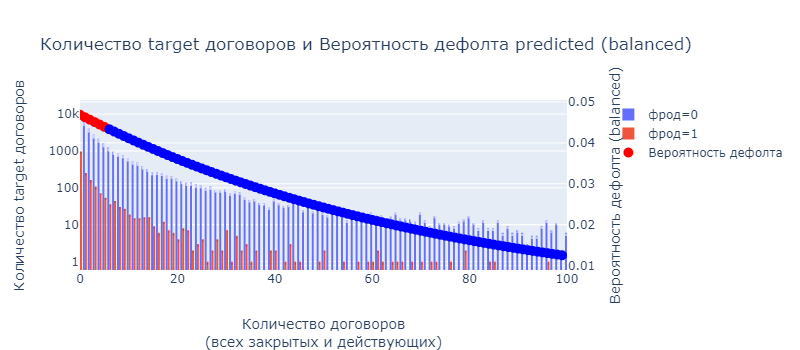

In [50]:
#  вывод исходных данных с вероятностями дефолта
y_pred, y_prob = log.predict(np.arange(0, 100))
df_second = pd.DataFrame({'X':np.arange(0, 100), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_cred.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='no_contracts_total', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[0, 100], 
                height= 350, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = get_feature_name('no_contracts_total', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

### Дефолтные сделки по активным договорам до даты принятия решения (кред метка)

{'rocauc': 0.51, 'accuracy': 0.26, 'recall': 0.79}
{'intercept': -0.0035, 'coef': array([-0.0992])}


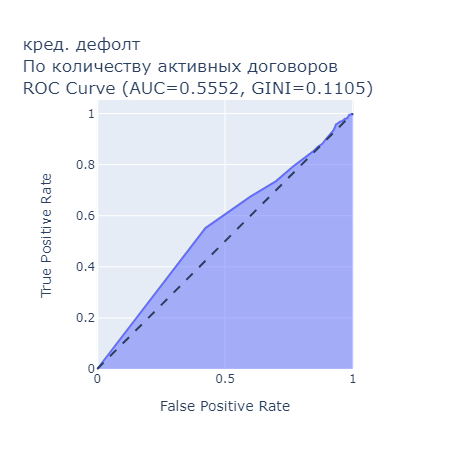

In [51]:
type = target_cred.type

X_raw = np.asarray(target_cred.data[['no_contracts_active']])
y = np.asarray(target_cred.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()

fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству активных договоров')

### Дефолтные сделки по всем договорам только по ТС до даты принятия решения (кред метка)

{'rocauc': 0.53, 'accuracy': 0.27, 'recall': 0.81}
{'intercept': -0.0081, 'coef': array([-0.1542])}


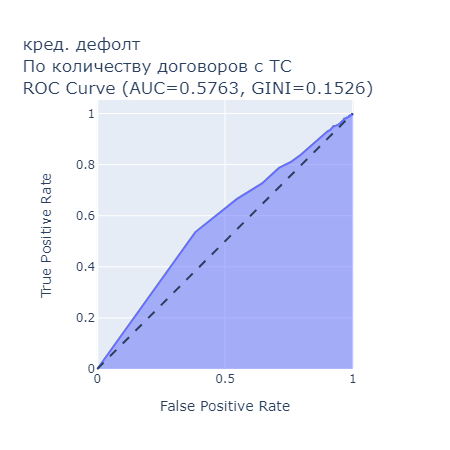

In [52]:
type = target_cred.type

X_raw = np.asarray(target_cred.data[['no_transport_total']])
y = np.asarray(target_cred.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()

fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству договоров с ТС')

### Дефолтные сделки по активным договорам только по ТС до даты принятия решения (кред метка)

{'rocauc': 0.51, 'accuracy': 0.28, 'recall': 0.77}
{'intercept': -0.0016, 'coef': array([-0.0635])}


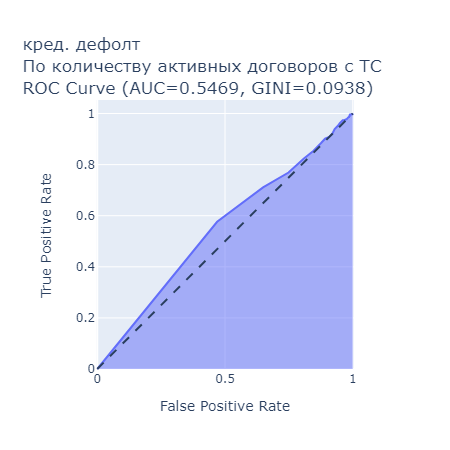

In [53]:
type = target_cred.type

X_raw = np.asarray(target_cred.data[['no_transp_active']])
y = np.asarray(target_cred.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()

fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству активных договоров с ТС')

Вывод: если брать во внимание только договоры с транспортными средствами, то AUC немного падает, по сравнению со всеми договорами

In [54]:
# сохраняем tmp таблицы
if len(writer.sheets):
    writer.save()